In [1]:
import warnings 
warnings.filterwarnings('ignore')

from typing import List

from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
pd.set_option('display.max_rows', None)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict, GridSearchCV
from sklearn.linear_model import LassoCV, ElasticNetCV, Lasso, Ridge, ElasticNet # basically no use with linear models
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance

from xgboost import XGBRegressor 


from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error, mean_absolute_error, PredictionErrorDisplay

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [2]:
trainData = pd.read_csv('../data/train.csv')
testData = pd.read_csv('../data/test.csv')
addData = pd.read_csv('../data/addData.csv')

trainData.drop('id', axis = 1, inplace = True)
trainData = pd.concat([trainData, addData], axis = 0) # addData to TrainData

In [3]:
trainData.head()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


In [4]:
testData.head()

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
0,524164,0.410013,-16.794967,0.023500,0.232910,0.012689,0.271585,0.664321,302901.5498,0.424867
1,524165,0.463071,-1.357000,0.141818,0.057725,0.257942,0.097624,0.829552,221995.6643,0.846000
2,524166,0.686569,-3.368928,0.167851,0.287823,0.210915,0.325909,0.304978,357724.0127,0.134067
3,524167,0.885793,-5.598049,0.118488,0.000005,0.376906,0.134435,0.487740,271790.3989,0.316467
4,524168,0.637391,-7.068160,0.126099,0.539073,0.068950,0.024300,0.591248,277728.5383,0.481067


In [5]:
trainData.describe().drop('count')

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
mean,0.631880,-8.380714,0.074701,0.263394,0.118214,0.178798,0.554971,241899.351148,0.500912,119.033103
std,0.157582,4.619296,0.050205,0.223561,0.132670,0.118700,0.225995,59554.635985,0.289920,26.470721
min,0.076900,-27.509725,0.023500,0.000005,0.000001,0.024300,0.025600,63973.000000,0.000067,46.718000
25%,0.514538,-11.555531,0.023500,0.069344,0.000001,0.077599,0.403470,206940.174200,0.254867,101.053280
50%,0.634288,-8.252399,0.066545,0.242689,0.074427,0.166575,0.564293,243623.139800,0.511800,118.747660
75%,0.739069,-4.911769,0.107757,0.397750,0.204909,0.269935,0.716385,281896.422800,0.746133,136.686590
max,0.975000,-1.357000,0.346387,0.995000,0.890385,0.803157,0.978000,519650.691100,1.000000,206.037000


In [6]:
testData.describe().drop('count')

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
mean,611524.500000,0.632591,-8.377495,0.074475,0.262903,0.117407,0.178317,0.555861,241753.736419,0.500545
std,50438.041204,0.157229,4.622288,0.050024,0.222899,0.131628,0.118165,0.226218,59103.896616,0.290550
min,524164.000000,0.140859,-27.442731,0.023500,0.000005,0.000001,0.024300,0.025600,63973.000000,0.000067
25%,567844.250000,0.514918,-11.550095,0.023500,0.069448,0.000001,0.077821,0.403788,207518.151300,0.253817
50%,611524.500000,0.634556,-8.253186,0.066432,0.242412,0.073968,0.165956,0.566015,243584.585400,0.511867
75%,655204.750000,0.739179,-4.903740,0.107302,0.396870,0.202977,0.268133,0.716694,281737.445300,0.746133
max,698885.000000,0.975000,-1.357000,0.258857,0.995000,0.680914,0.599544,0.978000,449288.808400,0.999867


In [7]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 538797 entries, 0 to 14632
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   RhythmScore                538797 non-null  float64
 1   AudioLoudness              538797 non-null  float64
 2   VocalContent               538797 non-null  float64
 3   AcousticQuality            538797 non-null  float64
 4   InstrumentalScore          538797 non-null  float64
 5   LivePerformanceLikelihood  538797 non-null  float64
 6   MoodScore                  538797 non-null  float64
 7   TrackDurationMs            538797 non-null  float64
 8   Energy                     538797 non-null  float64
 9   BeatsPerMinute             538797 non-null  float64
dtypes: float64(10)
memory usage: 45.2 MB


In [8]:
testData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174722 entries, 0 to 174721
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         174722 non-null  int64  
 1   RhythmScore                174722 non-null  float64
 2   AudioLoudness              174722 non-null  float64
 3   VocalContent               174722 non-null  float64
 4   AcousticQuality            174722 non-null  float64
 5   InstrumentalScore          174722 non-null  float64
 6   LivePerformanceLikelihood  174722 non-null  float64
 7   MoodScore                  174722 non-null  float64
 8   TrackDurationMs            174722 non-null  float64
 9   Energy                     174722 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 13.3 MB


In [9]:
print('Train data ->', trainData.shape)
print('Test data ->', testData.shape)

Train data -> (538797, 10)
Test data -> (174722, 10)


## 1. `Data Preprocessing`

In [10]:
# handle nulls
print('nulls in train ->', trainData.isnull().sum().sum())
print('nulls in test ->', testData.isnull().sum().sum())

nulls in train -> 0
nulls in test -> 0


In [11]:
# handle duplicates
print('duplicates in train ->', trainData.duplicated().sum())
print('duplicates in test ->', testData.duplicated().sum())

duplicates in train -> 0
duplicates in test -> 0


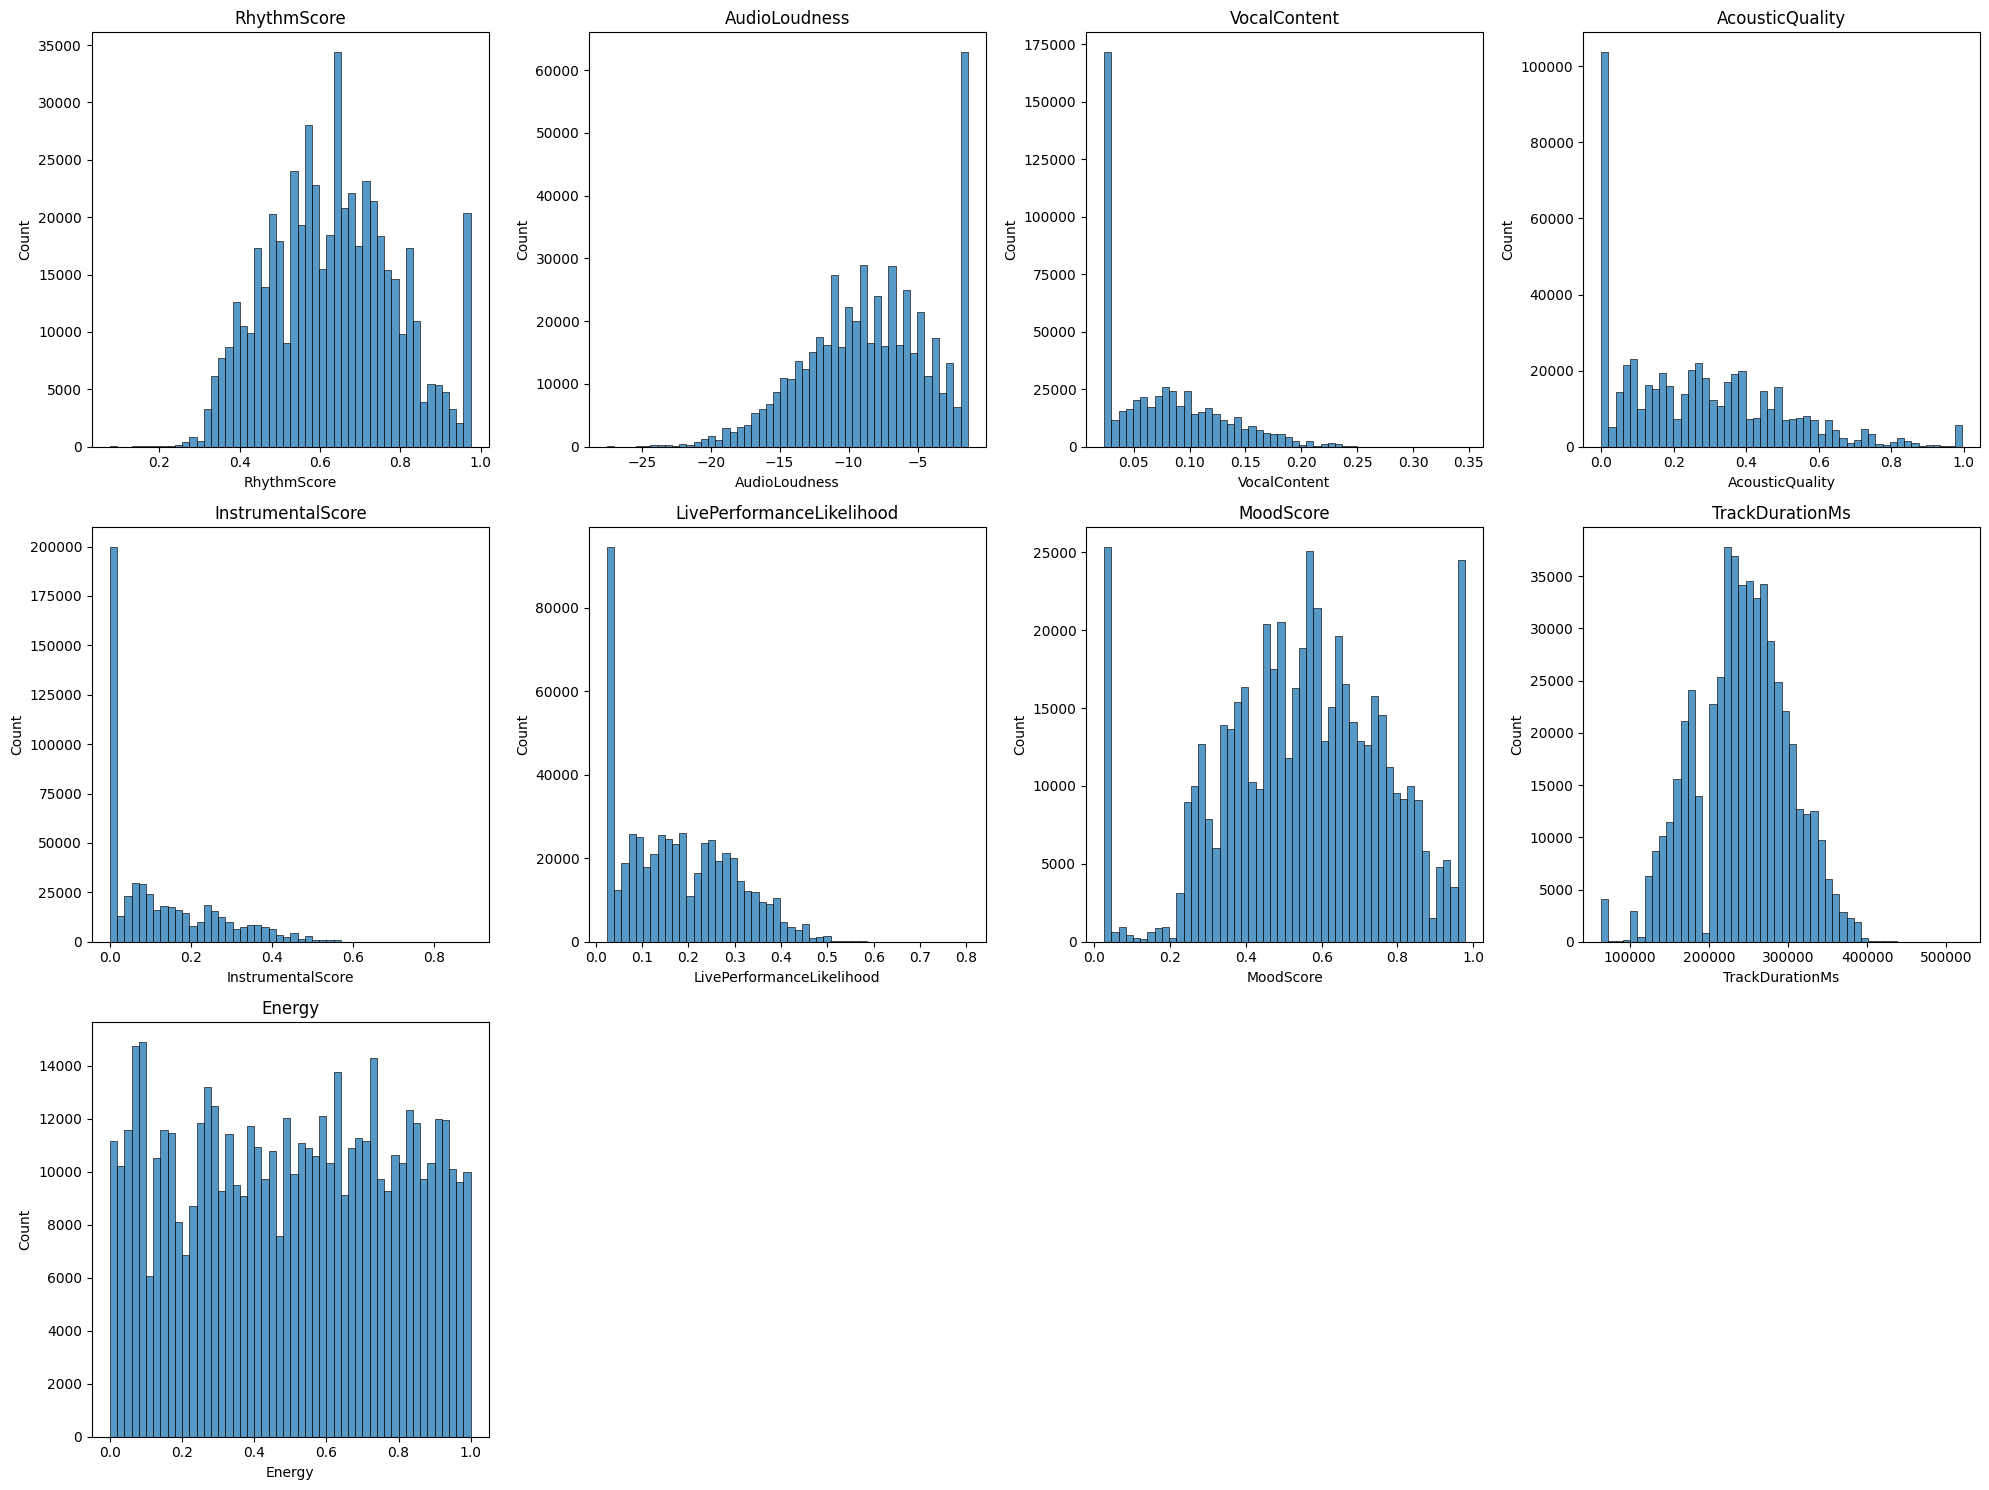

In [12]:
# handle outliers
# 1. plotting outliers

COLUMNS = list(testData.columns)[1:]
def featureDist(trainData : pd.DataFrame) -> None:
    ncols = 4
    nrows = -(-len(COLUMNS) // ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5*nrows))

    axes = axes.flatten()

    for ax, col in zip(axes, COLUMNS):
        sns.histplot(trainData[col].dropna(), bins=50, ax=ax)
        ax.set_title(col)

    for ax in axes[len(COLUMNS):]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()

featureDist(trainData)

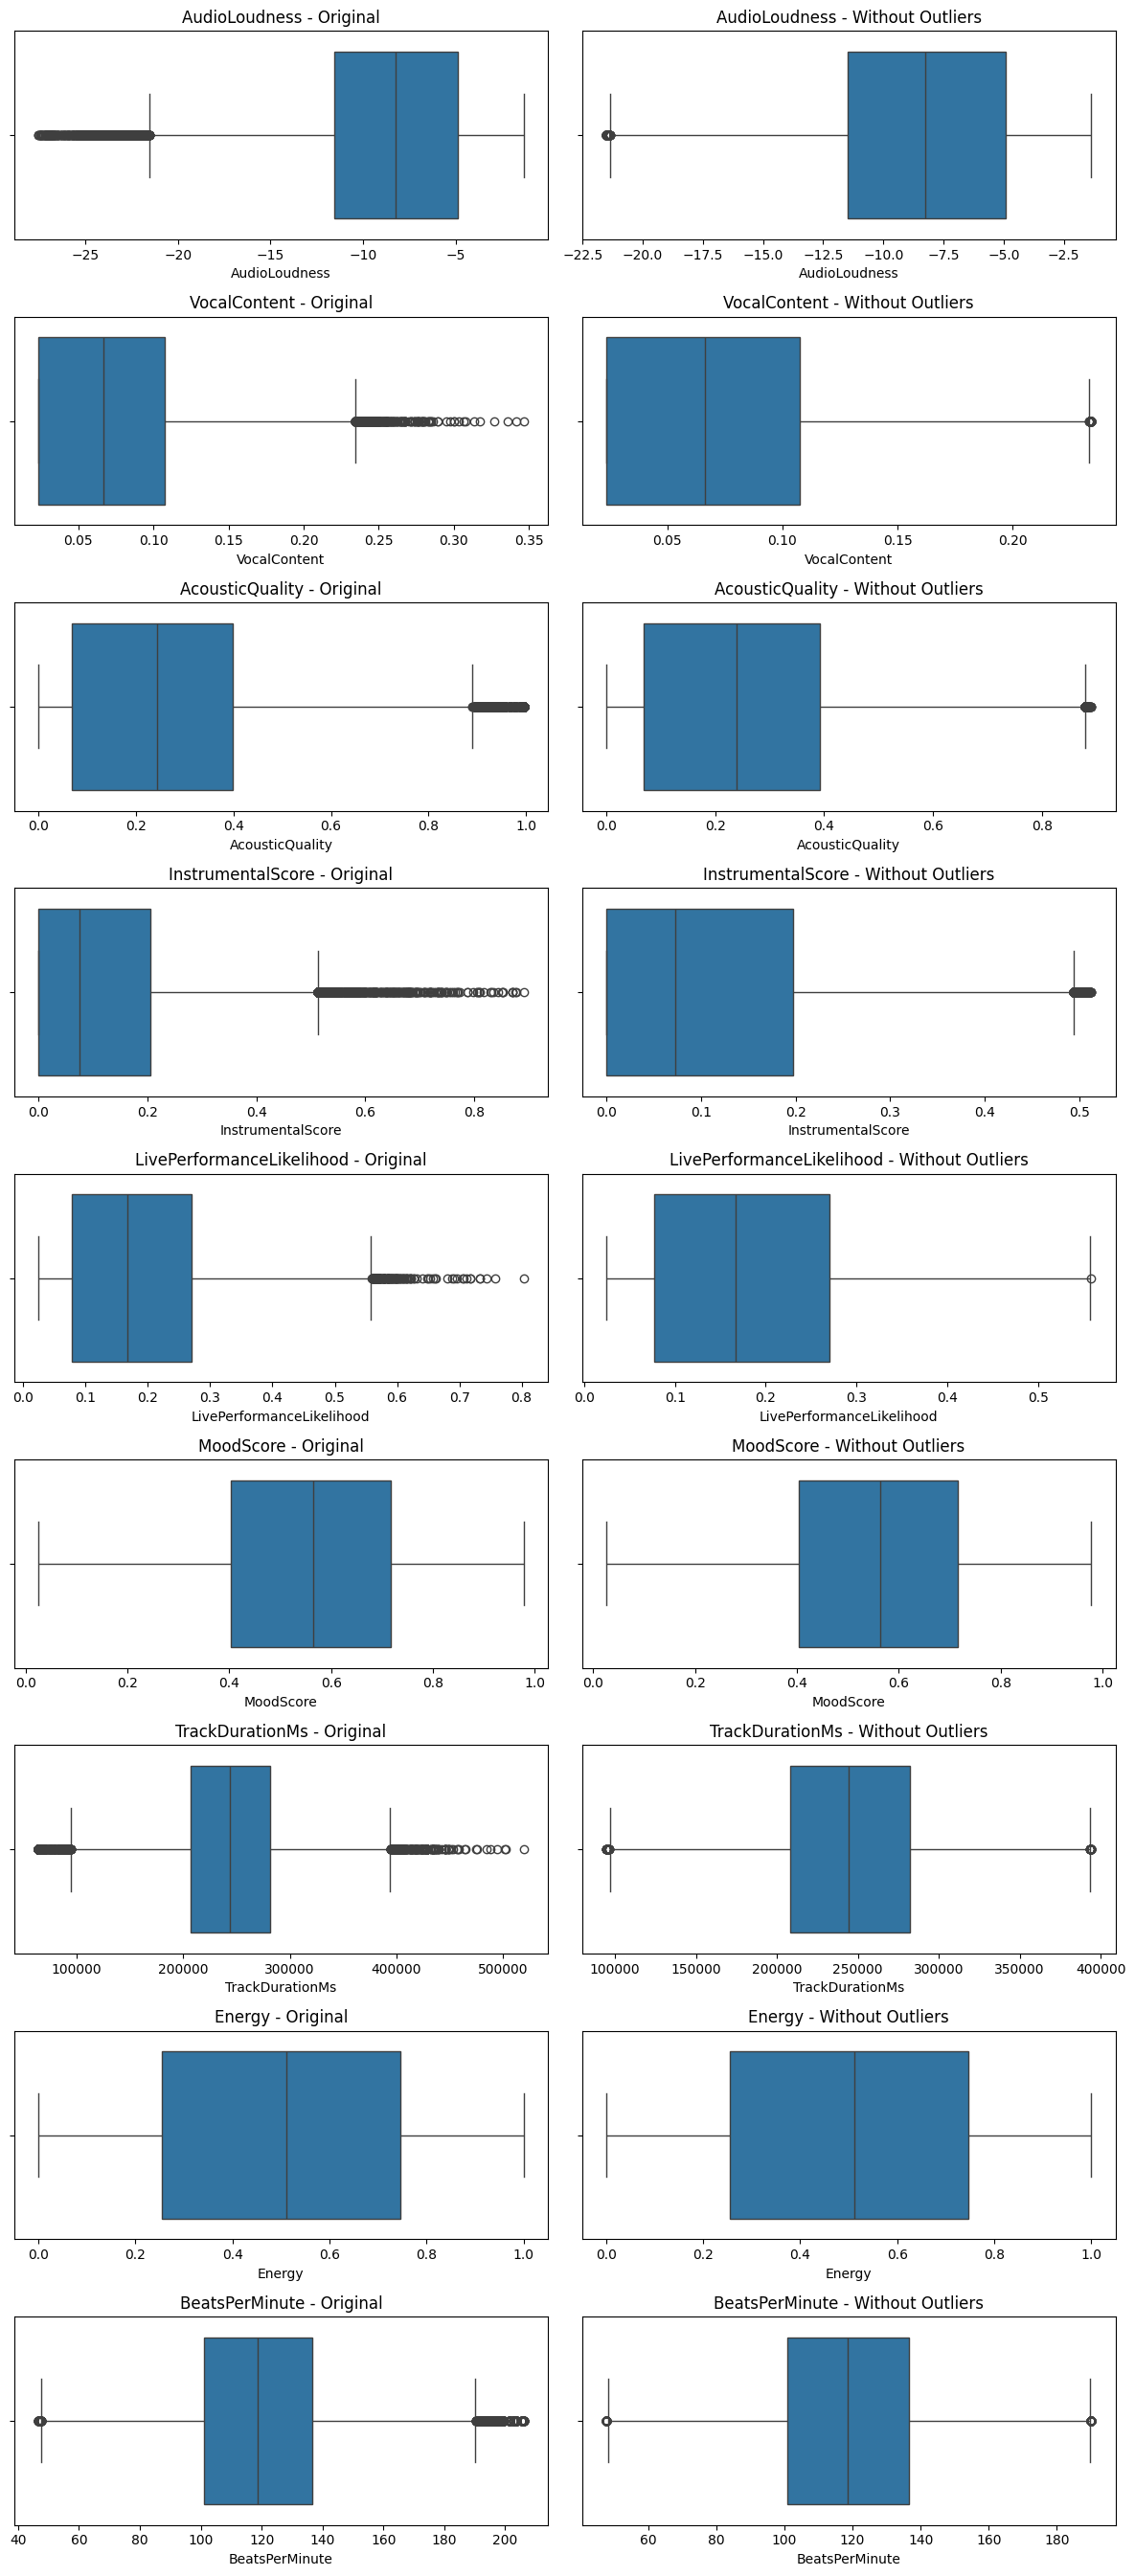

In [13]:
nrows = len(COLUMNS)

fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(12, 3*nrows))

for i, col in enumerate(list(trainData.columns)[1:]):
    data = trainData[col]
    
    sns.boxplot(x=data, ax=axes[i, 0])
    axes[i, 0].set_title(f"{col} - Original")
    
    Q1, Q3 = np.quantile(data, [0.25, 0.75])
    IQR = Q3 - Q1
    filtered = data[(data >= Q1 - 1.5*IQR) & (data <= Q3 + 1.5*IQR)]
    
    sns.boxplot(x=filtered, ax=axes[i, 1])
    axes[i, 1].set_title(f"{col} - Without Outliers")

plt.tight_layout()
plt.show()

In [14]:
# Remove outliers
for col in COLUMNS:
    data = trainData[col]
    
    Q1, Q3 = np.quantile(data, [0.25, 0.75])
    IQR = Q3 - Q1
    
    # Keep only non-outliers
    trainData = trainData[(data >= Q1 - 1.5*IQR) & (data <= Q3 + 1.5*IQR)]

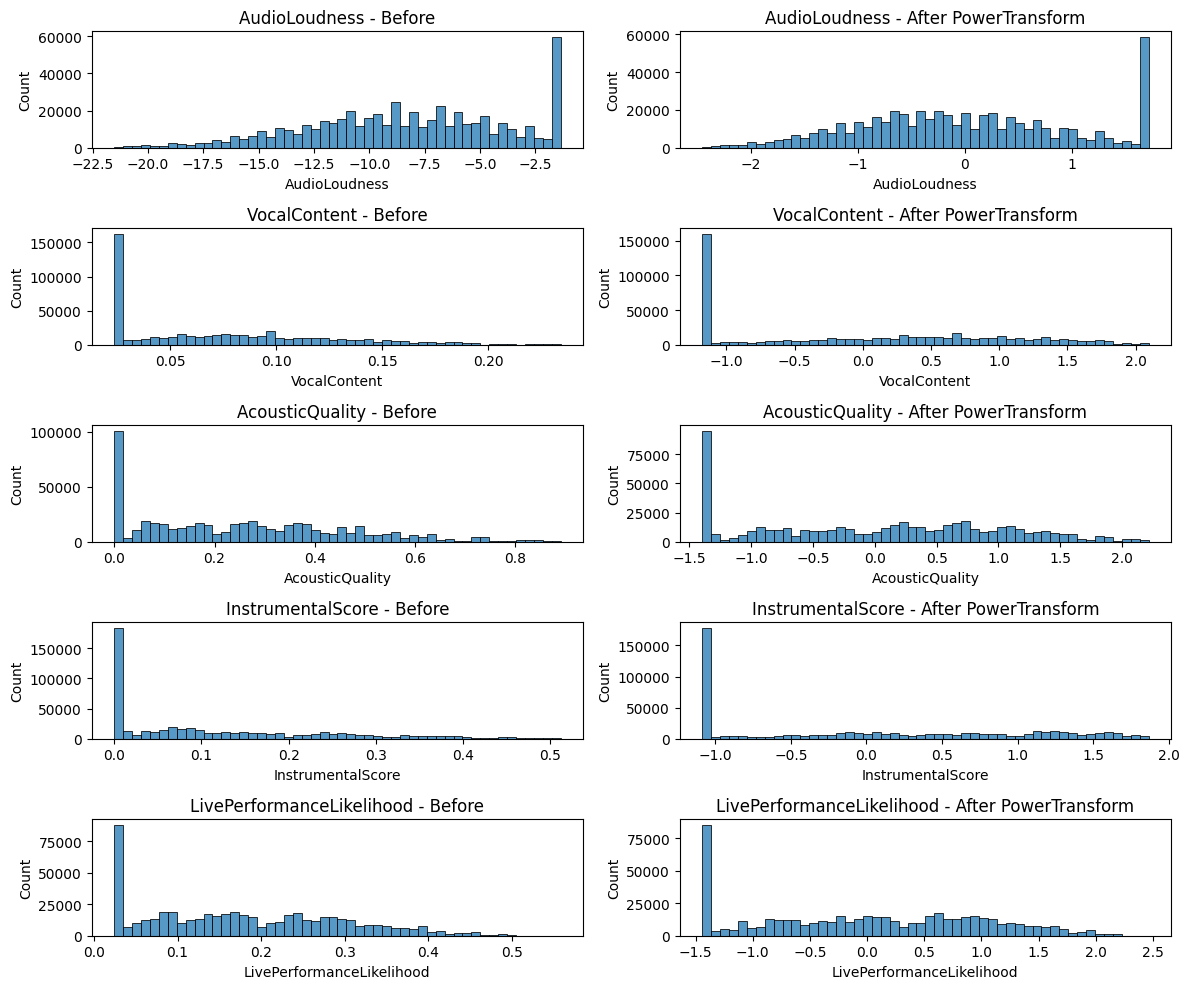

In [16]:
expCols = ['AudioLoudness','VocalContent','AcousticQuality','InstrumentalScore','LivePerformanceLikelihood']

trainTransformed = trainData.copy()

pt = PowerTransformer(method='yeo-johnson')
trainTransformed[expCols] = pt.fit_transform(trainTransformed[expCols])

ncols = 2
nrows = len(expCols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 2*nrows))

for i, col in enumerate(expCols):
    sns.histplot(trainData[col], bins=50, ax=axes[i,0])
    axes[i,0].set_title(f'{col} - Before')
    
    sns.histplot(trainTransformed[col], bins=50, ax=axes[i,1])
    axes[i,1].set_title(f'{col} - After PowerTransform')

plt.tight_layout()
plt.show()

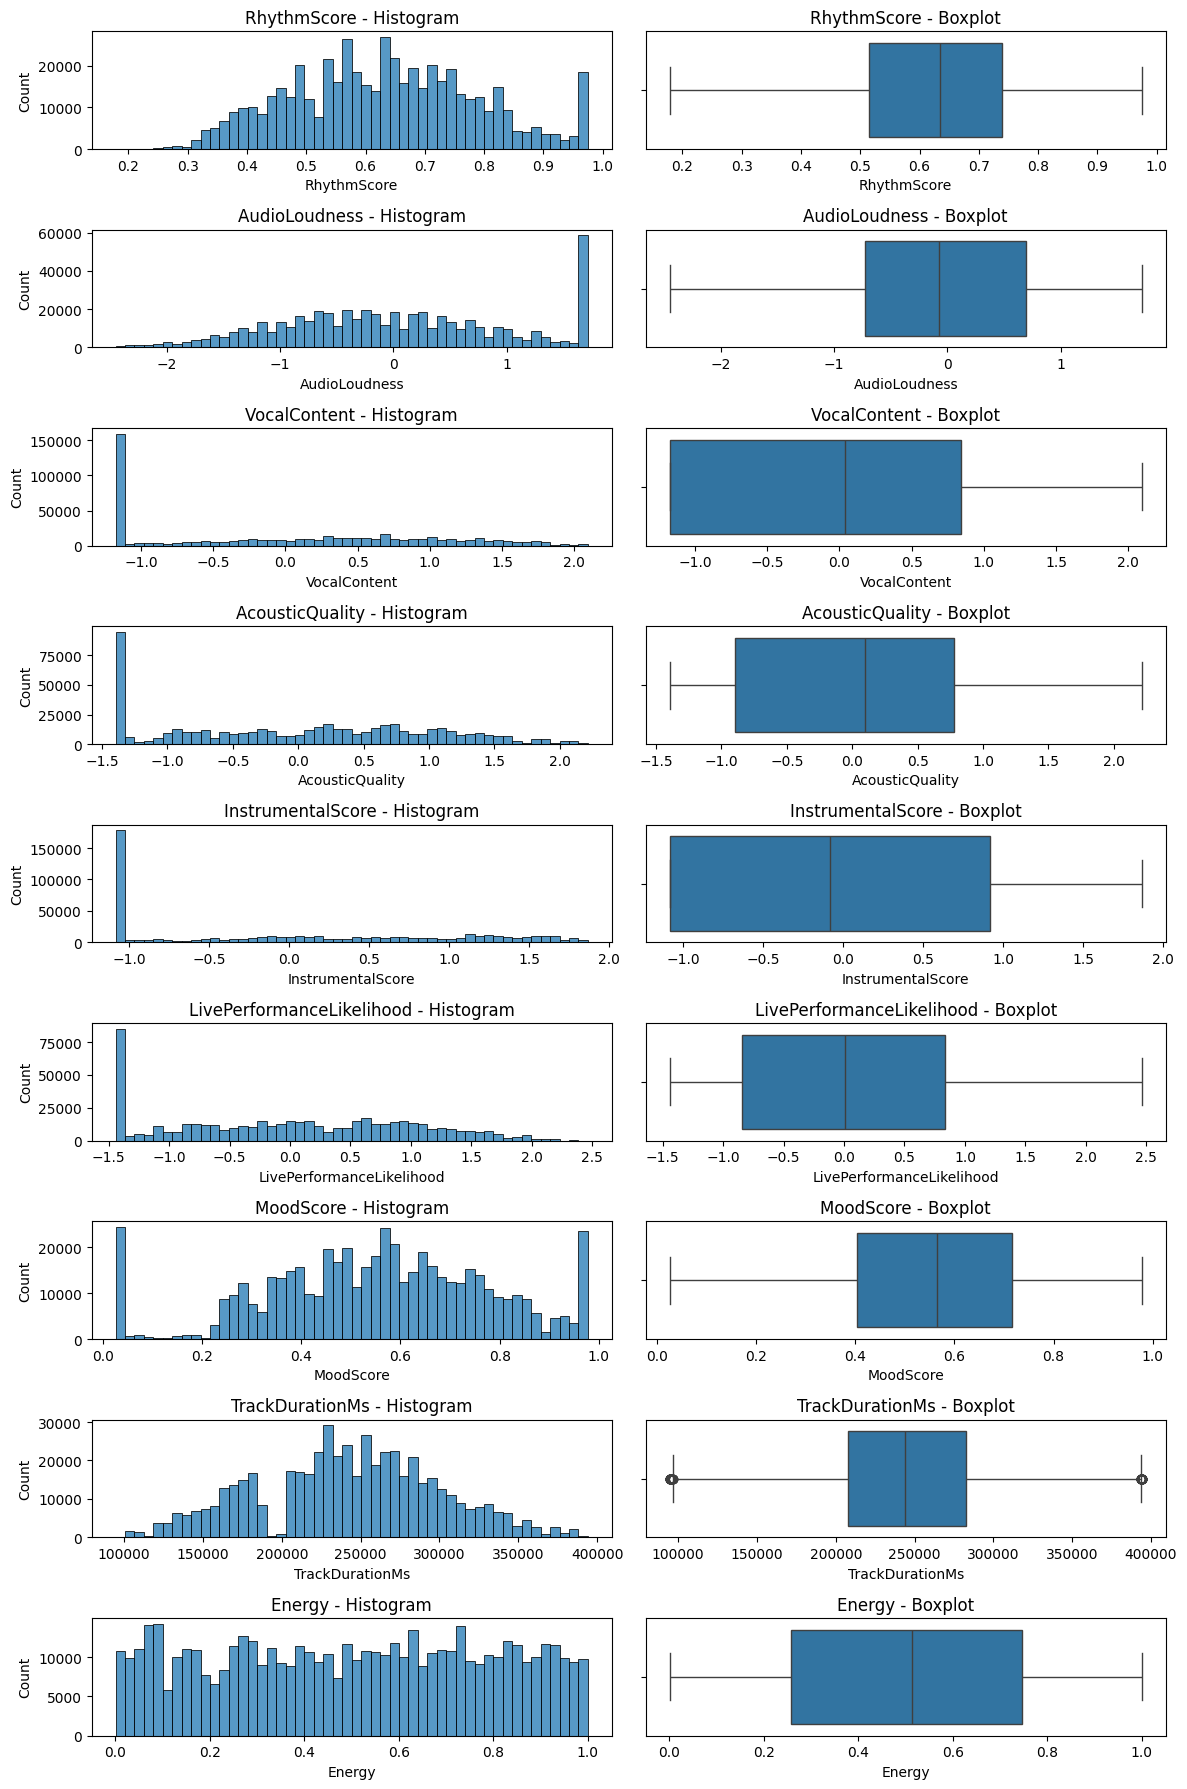

In [17]:
# use standardization using a scaler
expCols = ['AudioLoudness','VocalContent','AcousticQuality','InstrumentalScore','LivePerformanceLikelihood']

trainTransformed = trainData.copy()
testTransformed = testData.copy()

pt = PowerTransformer(method = 'yeo-johnson')
trainTransformed[expCols] = pt.fit_transform(trainTransformed[expCols])
testTransformed[expCols] = pt.transform(testTransformed[expCols])

ncols = 2
nrows = len(COLUMNS)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 2*nrows))

for i, col in enumerate(COLUMNS):
    sns.histplot(trainTransformed[col], bins=50, ax=axes[i,0])
    axes[i,0].set_title(f'{col} - Histogram')
    
    sns.boxplot(x=trainTransformed[col], ax=axes[i,1])
    axes[i,1].set_title(f'{col} - Boxplot')

plt.tight_layout()
plt.show()

In [18]:
print(trainTransformed.shape)
print(testTransformed.shape)

(520782, 10)
(174722, 10)


### `Model Training`

In [19]:
trainTransformed.describe().drop('count')

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
mean,0.631902,7.943127e-16,-4.957599e-16,4.582122e-16,-2.199375e-17,4.256855e-17,0.554936,243195.629609,0.502322,119.036661
std,0.157439,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.225926,57526.012504,0.289647,26.465296
min,0.178153,-2.451863e+00,-1.176859e+00,-1.397017e+00,-1.087131e+00,-1.442743e+00,0.025600,94492.675070,0.000067,46.718000
25%,0.513981,-7.297895e-01,-1.176859e+00,-8.994946e-01,-1.087131e+00,-8.436598e-01,0.403513,208047.388800,0.256867,101.072820
50%,0.634281,-7.318543e-02,4.201931e-02,9.793690e-02,-8.088388e-02,1.200820e-02,0.564292,244058.754050,0.513867,118.751410
75%,0.739069,6.946329e-01,8.408489e-01,7.761185e-01,9.178891e-01,8.326422e-01,0.716298,282288.717425,0.746733,136.686530
max,0.975000,1.716400e+00,2.095540e+00,2.215309e+00,1.866754e+00,2.463141e+00,0.978000,394206.809400,1.000000,206.037000


In [20]:
testTransformed.describe().drop('count')

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
mean,611524.500000,0.632591,-0.007817,0.001411,0.028666,0.007900,-0.003077,0.555861,241753.736419,0.500545
std,50438.041204,0.157229,1.011684,1.002558,1.027162,1.004247,0.998577,0.226218,59103.896616,0.290550
min,524164.000000,0.140859,-3.338033,-1.176859,-1.397017,-1.087131,-1.442743,0.025600,63973.000000,0.000067
25%,567844.250000,0.514918,-0.741315,-1.176859,-0.894319,-1.087131,-0.842295,0.403788,207518.151300,0.253817
50%,611524.500000,0.634556,-0.075714,0.045496,0.109520,-0.070443,0.006807,0.566015,243584.585400,0.511867
75%,655204.750000,0.739179,0.694503,0.840066,0.792446,0.954575,0.819791,0.716694,281737.445300,0.746133
max,698885.000000,0.975000,1.716400,2.222994,2.425695,2.042030,2.640393,0.978000,449288.808400,0.999867


In [21]:
def trainModel(model, X_train, y_train):
    pred_oof = cross_val_predict(model, X_train, y_train, cv=5, n_jobs=-1)

    mse = mean_squared_error(y_train, pred_oof)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_train, pred_oof)
    r2 = r2_score(y_train, pred_oof)

    result = pd.DataFrame([[model.__class__.__name__, mse, rmse, mae, r2]],
                          columns=["Model","MSE","RMSE","MAE","R2"])

    residuals = y_train - pred_oof

    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    sns.scatterplot(x=pred_oof, y=y_train, ax=ax[0])
    ax[0].set_title("Predicted vs Actual")
    sns.histplot(residuals, bins=30, kde=True, ax=ax[1])
    ax[1].set_title("Residuals Distribution")
    plt.show()

    return result

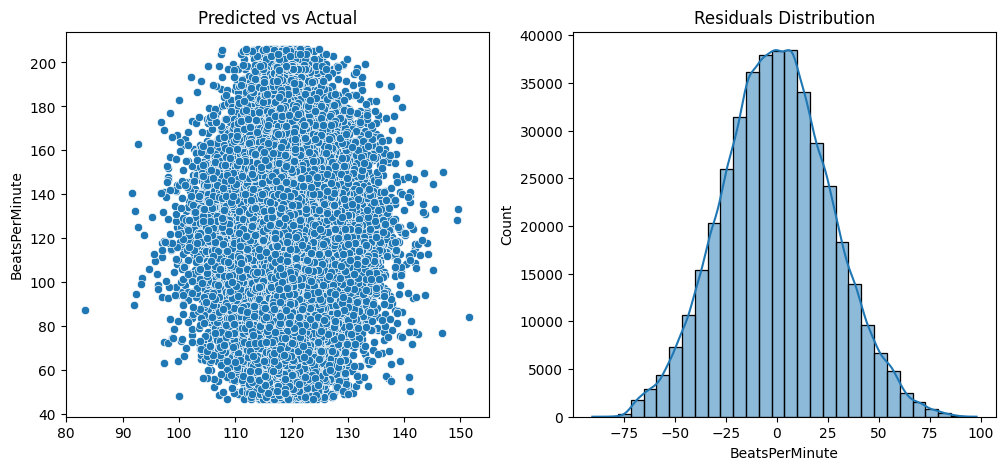

,Model,MSE,RMSE,MAE,R2
0,XGBRegressor,708.081713,26.609805,21.307078,-0.009314


In [22]:
def dataSplit(trainData : pd.DataFrame, features : pd.Series) -> List[np.ndarray]:
    X = trainData.drop('BeatsPerMinute', axis = 1)
    y = trainData['BeatsPerMinute']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    
    return [X_train, X_test, y_train, y_test]

X_train, X_test, y_train, y_test = dataSplit(trainData, trainData.drop('BeatsPerMinute', axis=1).columns)
features = X_train.columns
results = pd.concat([
    trainModel(XGBRegressor(), X_train, y_train),
], ignore_index=True)

results.head()

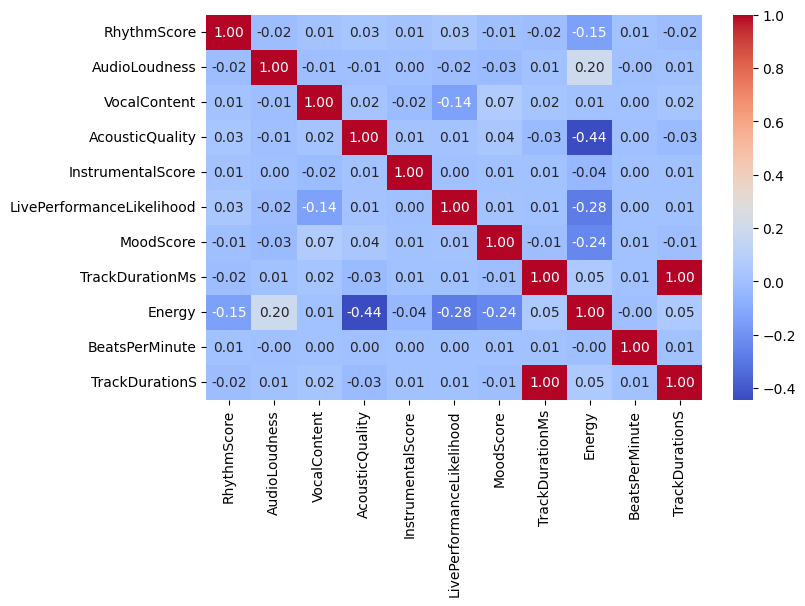

RhythmScore                  0.005318
AudioLoudness               -0.002675
VocalContent                 0.003575
AcousticQuality              0.000444
InstrumentalScore            0.002513
LivePerformanceLikelihood    0.004331
MoodScore                    0.007334
TrackDurationMs              0.007245
Energy                      -0.004747
BeatsPerMinute               1.000000
TrackDurationS               0.007245
Name: BeatsPerMinute, dtype: float64

In [29]:
# corr mat
def corrMatrix(trainData : pd.DataFrame, h: int = 5, w: int = 8) -> None:
    plt.figure(figsize=(w, h))
    sns.heatmap(trainData.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.show()
    
    return trainData.corr()['BeatsPerMinute']
    
corrMatrix(trainTransformed)

## `Feature Engineering`

In [35]:
# lets add some features coz, previous feartures are shit (see the correlation matrix). 
# lets add features looking at corr mat
trainTransformed['TrackDurationS'] = trainTransformed['TrackDurationMs'] / 1000

# Interaction features
trainTransformed['Rhythm_Energy'] = trainTransformed['RhythmScore'] * trainTransformed['Energy']
trainTransformed['Mood_Energy'] = trainTransformed['MoodScore'] * trainTransformed['Energy']
trainTransformed['Vocal_Instrumental'] = trainTransformed['VocalContent'] * trainTransformed['InstrumentalScore']

# Ratio features
trainTransformed['Energy_per_Second'] = trainTransformed['Energy'] / (trainTransformed['TrackDurationS'] + 1e-5)
trainTransformed['Mood_per_Second'] = trainTransformed['MoodScore'] / (trainTransformed['TrackDurationS'] + 1e-5)

# Sum features
trainTransformed['Audio_Rhythm_Score'] = trainTransformed['AudioLoudness'] + trainTransformed['RhythmScore']
trainTransformed['Performance_Score'] = trainTransformed['LivePerformanceLikelihood'] + trainTransformed['AcousticQuality']

# Optional: scaled duration in minutes
trainTransformed['TrackDurationM'] = trainTransformed['TrackDurationS'] / 60


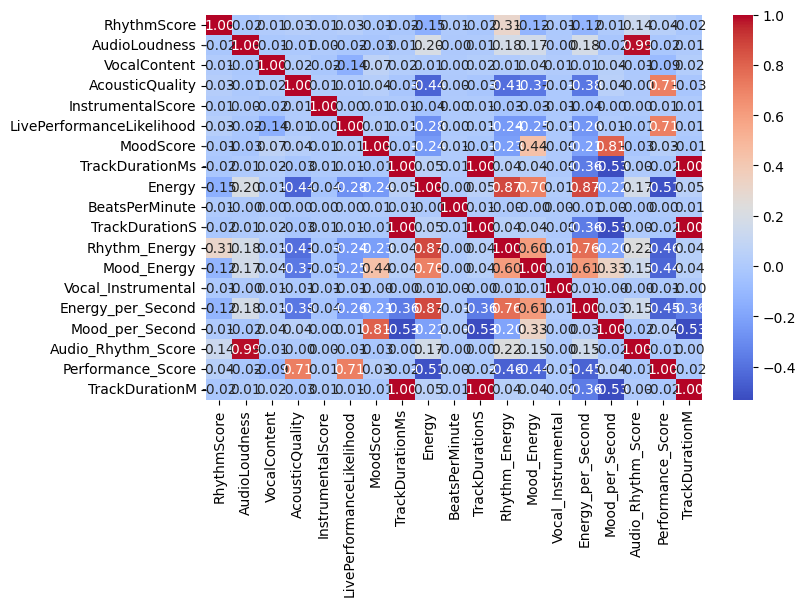

In [37]:
featureBPM = corrMatrix(trainTransformed)

In [38]:
featureBPM

RhythmScore                  0.005318
AudioLoudness               -0.002675
VocalContent                 0.003575
AcousticQuality              0.000444
InstrumentalScore            0.002513
LivePerformanceLikelihood    0.004331
MoodScore                    0.007334
TrackDurationMs              0.007245
Energy                      -0.004747
BeatsPerMinute               1.000000
TrackDurationS               0.007245
Rhythm_Energy               -0.001926
Mood_Energy                 -0.000893
Vocal_Instrumental           0.001245
Energy_per_Second           -0.006661
Mood_per_Second              0.001452
Audio_Rhythm_Score          -0.001821
Performance_Score            0.003359
TrackDurationM               0.007245
Name: BeatsPerMinute, dtype: float64

In [39]:
trainTransformed.head()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute,TrackDurationS,Rhythm_Energy,Mood_Energy,Vocal_Instrumental,Energy_per_Second,Mood_per_Second,Audio_Rhythm_Score,Performance_Score,TrackDurationM
0,0.603610,0.057443,-1.176859,-1.397017,-1.087131,-1.129882,0.409866,290715.6450,0.826267,147.53020,290.715645,0.498743,0.338659,1.279400,0.002842,0.001410,0.661052,-2.526899,4.845261
1,0.639451,-1.594443,0.160937,0.974641,1.540218,0.046725,0.651010,164519.5174,0.145400,136.15963,164.519517,0.092976,0.094657,0.247878,0.000884,0.003957,-0.954992,1.021366,2.741992
2,0.514538,-1.540452,0.894317,-0.253211,1.774601,-1.380285,0.423865,174495.5667,0.624667,55.31989,174.495567,0.321415,0.264774,1.587056,0.003580,0.002429,-1.025914,-1.633496,2.908259
3,0.734463,1.716400,-0.287188,-1.384284,0.684916,-0.752845,0.278745,225567.4651,0.487467,147.91212,225.567465,0.358026,0.135879,-0.196699,0.002161,0.001236,2.450862,-2.137129,3.759458
4,0.532968,-1.024385,-1.176859,-0.899468,-1.087131,1.249987,0.477769,213960.6789,0.947333,89.58511,213.960679,0.504899,0.452607,1.279400,0.004428,0.002233,-0.491417,0.350519,3.566011


In [40]:
baseline_pred = trainTransformed['BeatsPerMinute'].mean()
rmse_baseline = ((trainTransformed['BeatsPerMinute'] - baseline_pred)**2).mean()**0.5
print("Baseline RMSE:", rmse_baseline)

Baseline RMSE: 26.465270235387422


In [46]:
noise = np.random.uniform(-0.0005, 0.0005, size=len(testTransformed)) * trainTransformed['BeatsPerMinute'].mean()

sampleCSV = pd.DataFrame({
    'id': testTransformed['id'],
    'pred': trainTransformed['BeatsPerMinute'].mean() + noise
})

sampleCSV.to_csv('../data/submissions/meanSubmissionWithNoise.csv', index=False)